# Time Series Week 14 - Assignment

## 1. Import Module and Load Data

### 1.1. Import Necessary Libraries

In [1]:
# Install necessary libraries
!pip install yfinance tensorflow

In [2]:
# Google Mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [41]:
# Import libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv1D, Flatten, Dropout, TimeDistributed, MaxPooling1D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

### 1.2. Load Data

In [4]:
# TESLA || ticker = "TSLA" || 5 Years || Close Data(Univariate)
ticker = "TSLA"
data = yf.download(ticker, period="5y")
data = data[['Close']]
data.reset_index(inplace=True)
data.info()

[*********************100%***********************]  1 of 1 completed

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   (Date, )       1258 non-null   datetime64[ns]
 1   (Close, TSLA)  1258 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.8 KB


### 1.3. Data Visualization

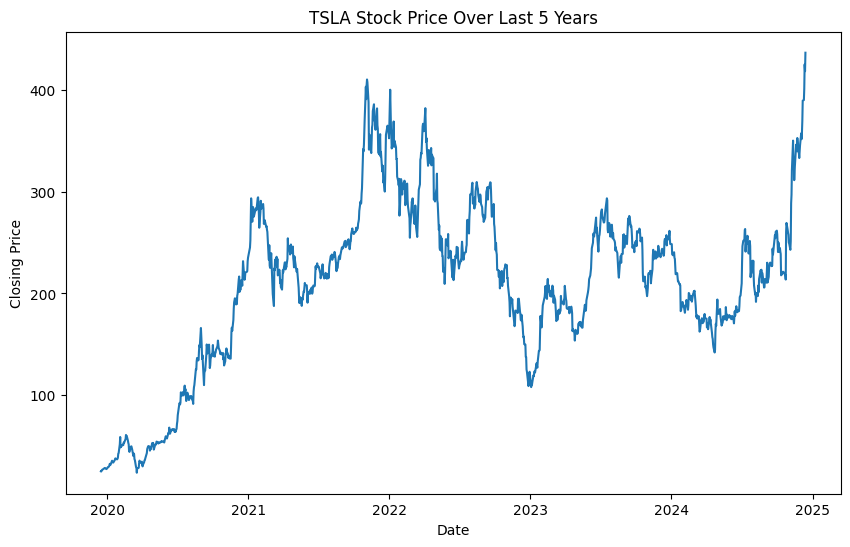

In [5]:
plt.figure(figsize=(10, 6))
plt.plot(data['Date'], data['Close'])
plt.title(f"{ticker} Stock Price Over Last 5 Years")
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.show()

## 2. Data Preprocessing

### 2.1. Data Preparation

In [6]:
def clean_data(series):
    """Fills missing values using linear interpolation."""
    series_filled = series.interpolate(method='linear')
    return series_filled

data['Close'] = clean_data(data['Close'])

In [7]:
def min_max_scale(dataframe):
    """Applies MinMax Scaling."""
    mm = MinMaxScaler()
    return mm.fit_transform(dataframe), mm

scaled_data, scaler = min_max_scale(data[['Close']])

### 2.2. Train-test split

In [8]:
def split_data(series, train_fraq, test_len=365):
    """Splits input series into train, validation, and test sets."""
    test_slice = len(series) - test_len
    test_data = series[test_slice:]
    train_val_data = series[:test_slice]
    train_size = int(len(train_val_data) * train_fraq)
    train_data = train_val_data[:train_size]
    val_data = train_val_data[train_size:]
    return train_data, val_data, test_data

train_data, val_data, test_data = split_data(scaled_data.flatten(), train_fraq=0.65, test_len=365)
look_back = 30

### 2.3. Reshape the data

In [9]:
def create_dataset(data, look_back=30):
    """Prepares time series data for model input."""
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:i + look_back])
        y.append(data[i + look_back])
    return np.array(X), np.array(y)

X_train, y_train = create_dataset(train_data, look_back)
X_val, y_val = create_dataset(val_data, look_back)
X_test, y_test = create_dataset(test_data, look_back)

# Reshape for models
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

## 3. Data Modelling

### 3.1. LSTM Model

In [10]:
# Model Configurations
loss = 'mean_squared_error'

In [36]:
# LSTM Model
lstm_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(look_back, 1)),
    LSTM(50),
    Dense(1)
], name='lstm')
lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss=loss, metrics=['mae'])
lstm_model.summary()



# My improve LSTM Model
improved_lstm_model = Sequential([
    LSTM(60, return_sequences=True, input_shape=(look_back, 1), kernel_initializer='he_normal'),
    Dropout(0.2),  # Dropout 추가
    LSTM(30, kernel_initializer='he_normal'),  # 유닛 수 점진적 감소
    Dropout(0.2),  # Dropout 추가
    Dense(1)  # 출력 레이어
], name='improved_lstm')

# 모델 컴파일
improved_lstm_model.compile(optimizer=Adam(learning_rate=0.001),
    loss=loss,
    metrics=['mae']
)
improved_lstm_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_37 (LSTM)                       │ (None, 30, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_38 (LSTM)                       │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

Model: "improved_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_39 (LSTM)                       │ (None, 30, 60)              │          14,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 30, 60)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_40 (LSTM)                       │ (None, 30)                  │          10,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 30)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 1)                   │              31 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,831 (100.90 KB)

 Trainable params: 25,831 (100.90 KB)

 Non-trainable params: 0 (0.00 B)

In [37]:
# Train LSTM and Store Training History
lstm_history = lstm_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10, batch_size=32, verbose=1
    )

# Train  my LSTM and Store Training History
improved_lstm_history = improved_lstm_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10, batch_size=32, verbose=1
    )

Epoch 1/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - loss: 0.1138 - mae: 0.2637 - val_loss: 0.0079 - val_mae: 0.0718
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0111 - mae: 0.0828 - val_loss: 0.0072 - val_mae: 0.0713
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0048 - mae: 0.0558 - val_loss: 0.0054 - val_mae: 0.0610
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0033 - mae: 0.0441 - val_loss: 0.0039 - val_mae: 0.0503
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0030 - mae: 0.0391 - val_loss: 0.0038 - val_mae: 0.0494
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0027 - mae: 0.0375 - val_loss: 0.0035 - val_mae: 0.0471
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0024 - mae: 0.0341 - val_loss: 0.0036 - val_mae: 0.0480
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0027 - mae: 0.0370 - val_loss: 0.0028 - val_mae: 0.0417
Epoch 9/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.002

### 3.2. LSTM-CNN Model

In [62]:
# LSTM-CNN Model
cnn_lstm_model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(look_back, 1)),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    LSTM(50),
    Dense(1)
], name='lstm-cnn')
cnn_lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss=loss, metrics=['mae'])
cnn_lstm_model.summary()

# My LSTM-CNN Model
improved_cnn_lstm_model = Sequential([
    Conv1D(128, kernel_size=3, activation='relu', input_shape=(look_back, 1)),
    MaxPooling1D(pool_size=2),
    Dropout(0.1),
    LSTM(64),  # LSTM 유닛 수 감소
    Dense(1)
], name='lstm-cnn')

improved_cnn_lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss=loss, metrics=['mae'])
improved_cnn_lstm_model.summary()

Model: "lstm-cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_25 (Conv1D)                   │ (None, 28, 64)              │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_25 (MaxPooling1D)      │ (None, 14, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_38 (Dropout)                 │ (None, 14, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_72 (LSTM)                       │ (None, 50)                  │          23,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_43 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,307 (91.04 KB)

 Trainable params: 23,307 (91.04 KB)

 Non-trainable params: 0 (0.00 B)

Model: "lstm-cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_26 (Conv1D)                   │ (None, 28, 128)             │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_26 (MaxPooling1D)      │ (None, 14, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_39 (Dropout)                 │ (None, 14, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_73 (LSTM)                       │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_44 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 49,985 (195.25 KB)

 Trainable params: 49,985 (195.25 KB)

 Non-trainable params: 0 (0.00 B)

In [63]:
# Train LSTM-CNN and Store Training History
cnn_lstm_history = cnn_lstm_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32, verbose=1)

# Train my LSTM-CNN and Store Training History
improved_cnn_lstm_history = improved_cnn_lstm_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32, verbose=1)


Epoch 1/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0776 - mae: 0.2123 - val_loss: 0.0040 - val_mae: 0.0523
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0050 - mae: 0.0547 - val_loss: 0.0035 - val_mae: 0.0484
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0034 - mae: 0.0457 - val_loss: 0.0030 - val_mae: 0.0440
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0035 - mae: 0.0442 - val_loss: 0.0028 - val_mae: 0.0423
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0024 - mae: 0.0346 - val_loss: 0.0031 - val_mae: 0.0445
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0031 - mae: 0.0401 - val_loss: 0.0027 - val_mae: 0.0411
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0026 - mae: 0.0360 - val_loss: 0.0030 - val_mae: 0.0436
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0027 - mae: 0.0387 - val_loss: 0.0029 - val_mae: 0.0428
Epoch 9/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.002

### 3.3. Evaluation of Training

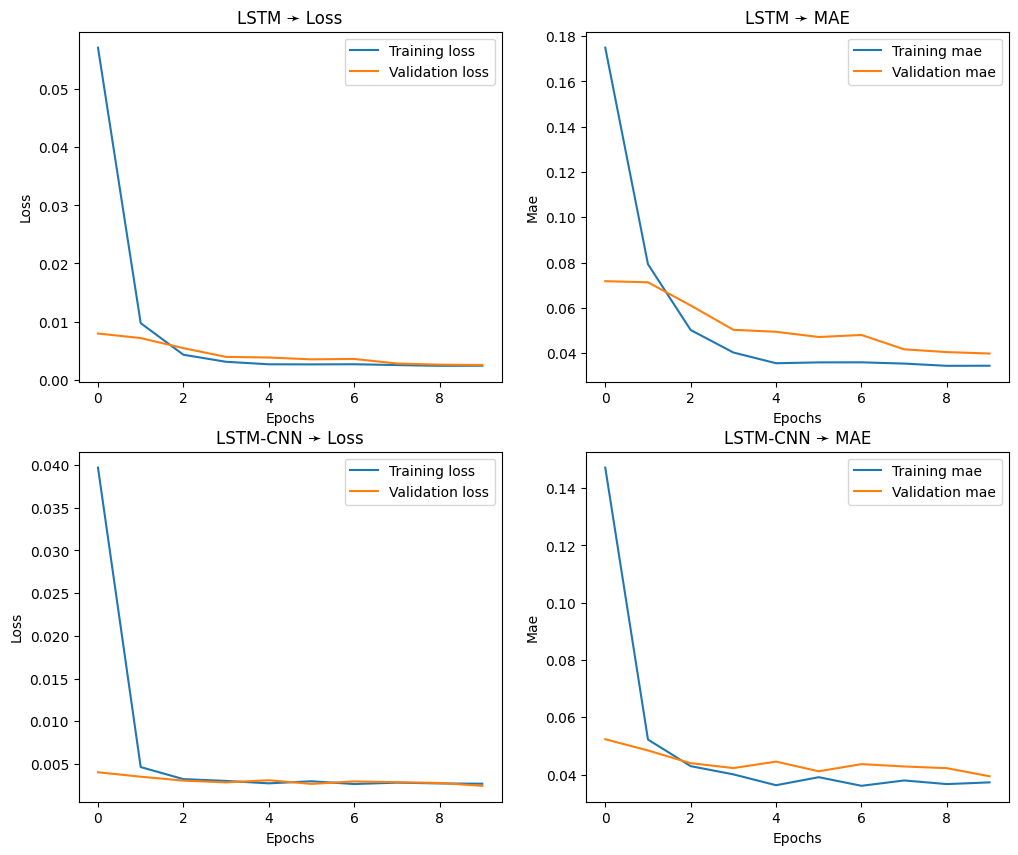

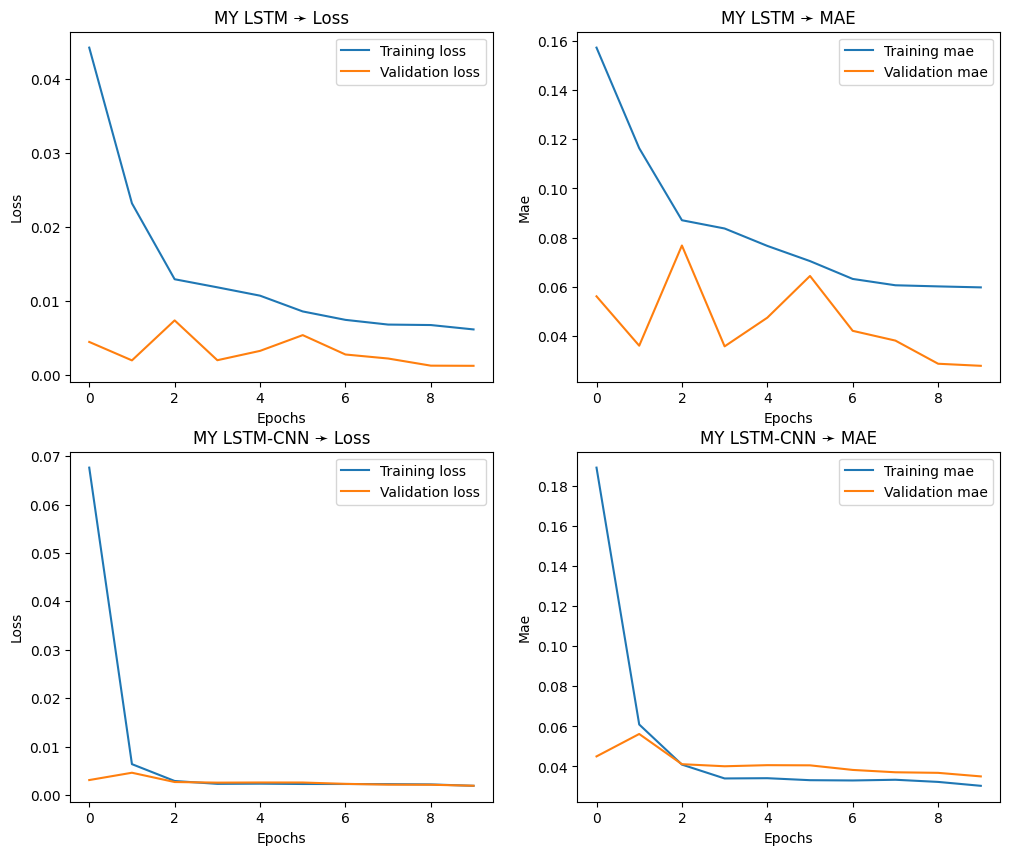

In [65]:
# Evaluation Graphs
def eval_graphs(metric, history, ax, title=None):
    """
    Plots training and validation metrics for a model.
    """
    ax.plot(history.history[metric], label=f"Training {metric}")
    ax.plot(history.history[f"val_{metric}"], label=f"Validation {metric}")
    ax.set_title(title or metric)
    ax.set_xlabel('Epochs')
    ax.set_ylabel(metric.capitalize())
    ax.legend()

fig, axs = plt.subplots(2, 2, figsize=(12, 10))

eval_graphs('loss', lstm_history, axs[0, 0], title="LSTM ➛ Loss")
eval_graphs('mae', lstm_history, axs[0, 1], title="LSTM ➛ MAE")

eval_graphs('loss', cnn_lstm_history, axs[1, 0], title="LSTM-CNN ➛ Loss")
eval_graphs('mae', cnn_lstm_history, axs[1, 1], title="LSTM-CNN ➛ MAE")

plt.tight_layout
plt.show()



fig, axs = plt.subplots(2, 2, figsize=(12, 10))

eval_graphs('loss', improved_lstm_history, axs[0, 0], title="MY LSTM ➛ Loss")
eval_graphs('mae', improved_lstm_history, axs[0, 1], title="MY LSTM ➛ MAE")

eval_graphs('loss', improved_cnn_lstm_history, axs[1, 0], title="MY LSTM-CNN ➛ Loss")
eval_graphs('mae', improved_cnn_lstm_history, axs[1, 1], title="MY LSTM-CNN ➛ MAE")

plt.tight_layout
plt.show()

### 3.4. Predictions

In [16]:
def evaluate_model(model_name, y_actual, y_pred):
    """
    Prints and returns MAE and MAPE for a model's predictions.
    """
    mae = mean_absolute_error(y_actual, y_pred)
    mape = mean_absolute_percentage_error(y_actual, y_pred)
    print(f"{model_name} - MAE: {mae}, MAPE: {mape}")
    return mae, mape

lstm_pred = lstm_model.predict(X_test)
cnn_lstm_pred = cnn_lstm_model.predict(X_test)

lstm_pred_rescaled = scaler.inverse_transform(lstm_pred)
cnn_lstm_pred_rescaled = scaler.inverse_transform(cnn_lstm_pred)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

lstm_results = evaluate_model("LSTM", y_test_actual, lstm_pred_rescaled)
cnn_lstm_results = evaluate_model("LSTM-CNN", y_test_actual, cnn_lstm_pred_rescaled)

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
LSTM - MAE: 15.627218035797572, MAPE: 0.06846923597066878
LSTM-CNN - MAE: 15.509554006092582, MAPE: 0.06714155193661135


In [67]:
def evaluate_model(model_name, y_actual, y_pred):
    """
    Prints and returns MAE and MAPE for a model's predictions.
    """
    mae = mean_absolute_error(y_actual, y_pred)
    mape = mean_absolute_percentage_error(y_actual, y_pred)
    print(f"{model_name} - MAE: {mae}, MAPE: {mape}")
    return mae, mape

my_lstm_pred = improved_lstm_model.predict(X_test)
my_cnn_lstm_pred = improved_cnn_lstm_model.predict(X_test)

my_lstm_pred_rescaled = scaler.inverse_transform(my_lstm_pred)
my_cnn_lstm_pred_rescaled = scaler.inverse_transform(my_cnn_lstm_pred)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

my_lstm_results = evaluate_model("MY LSTM", y_test_actual, my_lstm_pred_rescaled)
my_cnn_lstm_results = evaluate_model("MY LSTM-CNN", y_test_actual, my_cnn_lstm_pred_rescaled)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
MY LSTM - MAE: 11.241145985162078, MAPE: 0.04894056981856827
MY LSTM-CNN - MAE: 13.379681533130247, MAPE: 0.0564510296737198


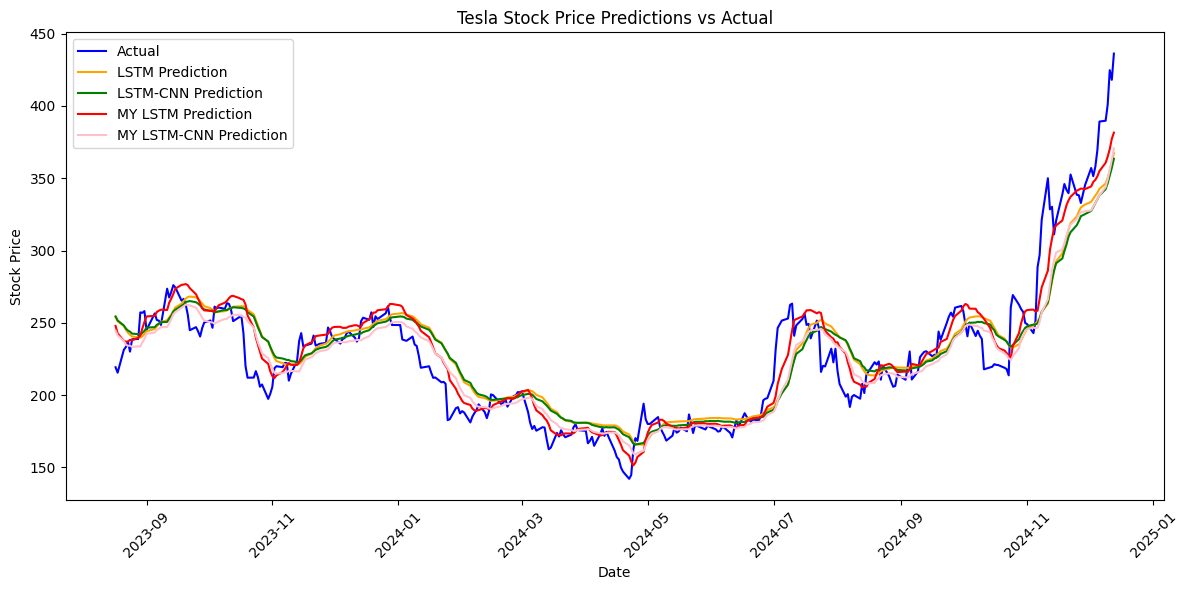

In [69]:
# Plot Predictions vs Actual
test_dates = data['Date'].iloc[-len(y_test_actual):].reset_index(drop=True)

plt.figure(figsize=(12, 6))
plt.plot(test_dates, y_test_actual, label="Actual", color='blue')
plt.plot(test_dates, lstm_pred_rescaled, label="LSTM Prediction", color='orange')
plt.plot(test_dates, cnn_lstm_pred_rescaled, label="LSTM-CNN Prediction", color='green')
plt.plot(test_dates, my_lstm_pred_rescaled, label="MY LSTM Prediction", color='red')
plt.plot(test_dates, my_cnn_lstm_pred_rescaled, label="MY LSTM-CNN Prediction", color='pink')
plt.legend()
plt.title("Tesla Stock Price Predictions vs Actual")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()